# Netflix Reviews with NLP
![neflix](https://media.zenfs.com/en/hypebeast_936/55dd2178cbbd27b2cdba3f8985a08d48)

Data Source: [Netflix Reviews](https://www.kaggle.com/datasets/ashishkumarak/netflix-reviews-playstore-daily-updated/data)

## Import packages

In [1]:
!pip install pyLDAvis

In [2]:
# import data processing and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# text processing and nlp
import nltk
from textblob import TextBlob

# gensim for topic modelling
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess

# additional visualization tool
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud, STOPWORDS

# for word embedding
from gensim.models import Word2Vec

# misc
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Load dataset

In [4]:
# load dataset and print top five head
df = pd.read_csv('netflix_reviews.csv')
df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,b3d27852-9a3b-4f74-9e16-15434d3ee324,Karen Gulli,Good,3,0,NaN,2024-06-22 15:41:54,NaN
1,8be10073-2368-4677-b828-9ff5d06ea0b7,Ronny Magadi,"App is useful to certain phone brand ,,,,it is...",1,0,8.105.0 build 15 50626,2024-06-22 05:16:03,8.105.0 build 15 50626
2,9ac001b4-a47e-4aba-981f-4679345a9664,Hushikesh Suvakiya,Always promoting anti-Hindu shows.,1,8,NaN,2024-06-18 09:52:52,NaN
3,abcc5ae3-c4e7-4a4d-b9c2-6d289cac70bc,Mann Official,No I'm not able to remove this app anymore 0 o...,1,0,NaN,2024-06-18 09:50:21,NaN
4,b0687627-7eb4-4c74-ac88-ba3cef068484,ashutosh gokani,Thy are supporting maharaj movie ...thts not a...,1,9,8.118.1 build 10 50703,2024-06-18 09:48:55,8.118.1 build 10 50703


In [5]:
# Check the column name
df.columns

Index(['reviewId', 'userName', 'content', 'score', 'thumbsUpCount',
       'reviewCreatedVersion', 'at', 'appVersion'],
      dtype='object')

In [6]:
# Check the shape of the dataframe
df.shape

(113607, 8)

## Pre-process the content

In [7]:
def preprocess(text):
  if isinstance(text, float):
    return ''
  text = text.lower() # lowercase
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # remove punctuation
  text = re.sub(r'\s+', ' ', text) # remove extra spaces
  return text

In [8]:
# Preprocess and create a new column named cleaned_content
df['cleaned_content'] = df['content'].apply(preprocess)
df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion,cleaned_content
0,b3d27852-9a3b-4f74-9e16-15434d3ee324,Karen Gulli,Good,3,0,NaN,2024-06-22 15:41:54,NaN,good
1,8be10073-2368-4677-b828-9ff5d06ea0b7,Ronny Magadi,"App is useful to certain phone brand ,,,,it is...",1,0,8.105.0 build 15 50626,2024-06-22 05:16:03,8.105.0 build 15 50626,app is useful to certain phone brand it is not...
2,9ac001b4-a47e-4aba-981f-4679345a9664,Hushikesh Suvakiya,Always promoting anti-Hindu shows.,1,8,NaN,2024-06-18 09:52:52,NaN,always promoting antihindu shows
3,abcc5ae3-c4e7-4a4d-b9c2-6d289cac70bc,Mann Official,No I'm not able to remove this app anymore 0 o...,1,0,NaN,2024-06-18 09:50:21,NaN,no im not able to remove this app anymore 0 ou...
4,b0687627-7eb4-4c74-ac88-ba3cef068484,ashutosh gokani,Thy are supporting maharaj movie ...thts not a...,1,9,8.118.1 build 10 50703,2024-06-18 09:48:55,8.118.1 build 10 50703,thy are supporting maharaj movie thts not acce...


In [9]:
# Check for missing value
df.isnull().sum()

reviewId                    0
userName                    2
content                     2
score                       0
thumbsUpCount               0
reviewCreatedVersion    16636
at                          0
appVersion              16636
cleaned_content             0
dtype: int64

In [10]:
# Fillup the null value with NaN
df.fillna('', inplace=True)

In [11]:
# Convert the df['at'] to datetime
df['at'] = pd.to_datetime(df['at'])

In [12]:
# Select the required column for the EDA
df_eda = df[['at', 'cleaned_content', 'score']]
df_eda.head()

,at,cleaned_content,score
0,2024-06-22 15:41:54,good,3
1,2024-06-22 05:16:03,app is useful to certain phone brand it is not...,1
2,2024-06-18 09:52:52,always promoting antihindu shows,1
3,2024-06-18 09:50:21,no im not able to remove this app anymore 0 ou...,1
4,2024-06-18 09:48:55,thy are supporting maharaj movie thts not acce...,1


## Exploratory Data Analysis

score
1    44576
2    10795
3    11964
4    13889
5    32383
Name: count, dtype: int64


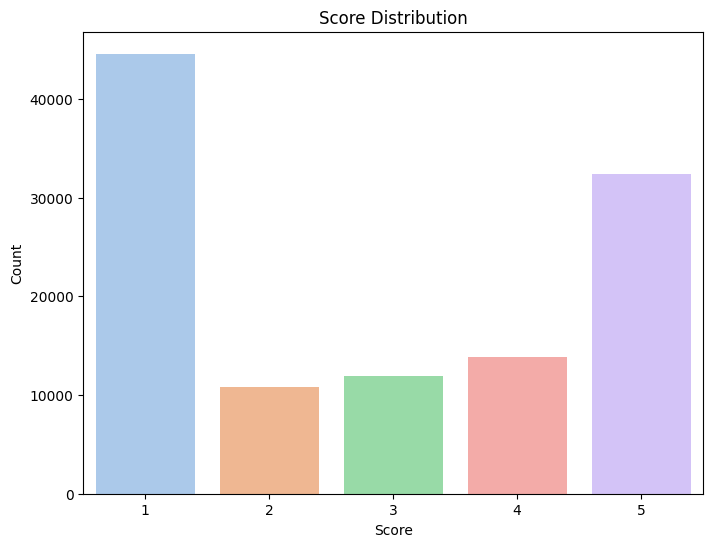

In [13]:
# Analyzing score distribution
score_counts = df_eda['score'].value_counts().sort_index()
print(score_counts)

# Visualize the score distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=score_counts.index, y=score_counts.values, palette='pastel')
plt.title('Score Distribution')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

In [14]:
# To get the sentiment
def get_sentiment(text):
  blob = TextBlob(text)
  return blob.sentiment.polarity

[TextBlob.Sentiment](https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis)

In [15]:
# Analyse the content and assign the sentiment
df_eda['sentiment'] = df_eda['cleaned_content'].apply(get_sentiment)
df_eda['sentiment_label'] = df_eda['sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Neutral' if x == 0 else 'Negative'))

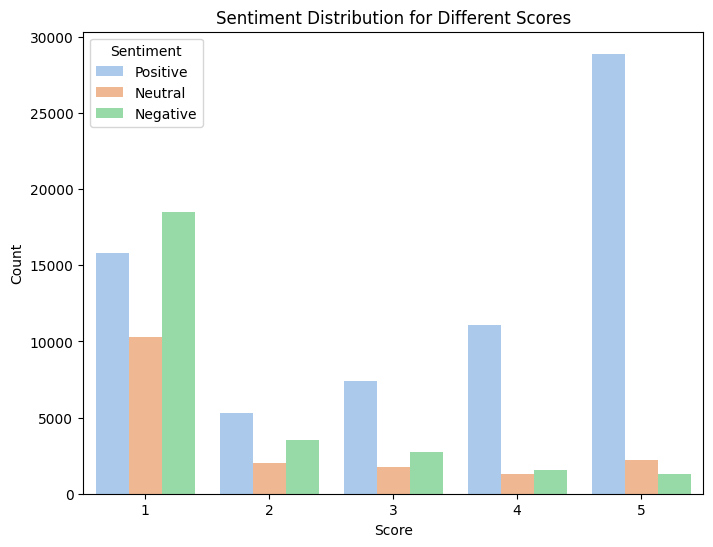

In [16]:
# Visualize the sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='score', data=df_eda, hue='sentiment_label', palette='pastel')
plt.title('Sentiment Distribution for Different Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

<font color='orange'>Observation</font>
* It makes sense that a larger portion of positive sentiment is found in scores of four and five, while scores of one have a higher portion of negative sentiment.


## Word Cloud
Analyzing the negative reviews

In [17]:
# Add the list of stopwords that related to netflix
stopwords = set(STOPWORDS)
stopwords.update(['netflix', 'movie', 'show', 'time', 'app', 'series', 'phone']) # create a custom list based on domain knowledge

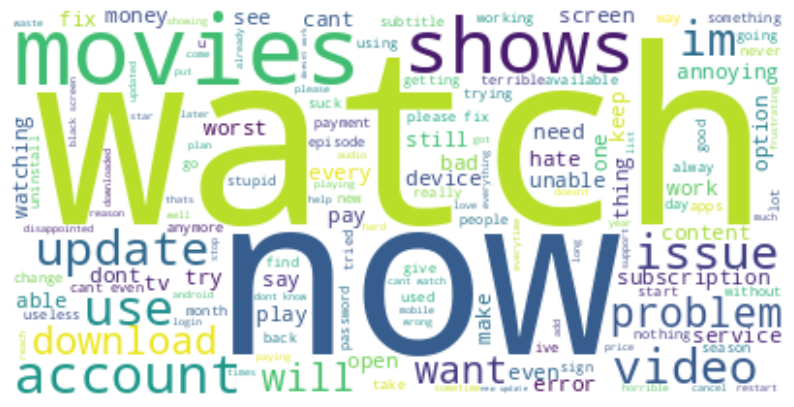

In [18]:
# Check the negative reviews and create word cloud
negative_reviews = df_eda[df_eda['sentiment_label'] == 'Negative']['cleaned_content'].tolist()
negative_reviews = ' '.join(negative_reviews)
wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(negative_reviews)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Topic Modelling

In [19]:
# Preprocess the text data in cleaned_content
def preprocess_text_data(text):
  tokens = nltk.word_tokenize(text)
  tokens = [word.lower() for word in tokens if word.isalpha()] # convert to lowercase and remove punctuation
  stopwords = set(nltk.corpus.stopwords.words('english'))
  tokens = [word for word in tokens if word not in stopwords] # remove stopwords
  return tokens

In [20]:
# Obtain the cleaned_content with negative sentiment
texts = df_eda[df_eda['sentiment_label'] == 'Negative']['cleaned_content'].apply(preprocess_text_data).tolist()

In [21]:
# Display some text
texts[:5]

[['worst',
  'customer',
  'service',
  'scripted',
  'refuse',
  'take',
  'responsibility',
  'provide',
  'compensation',
  'streaming',
  'services',
  'fail',
  'device',
  'clearly',
  'management',
  'lacking',
  'good',
  'business',
  'principles',
  'want',
  'make',
  'cheap',
  'buck'],
 ['useless', 'app', 'bludyyy', 'app', 'never', 'used', 'app', 'bakwas', 'app'],
 ['good', 'aap'],
 ['shows', 'device', 'failure', 'occurred', 'means'],
 ['worst',
  'subtitles',
  'ever',
  'done',
  'everyone',
  'needs',
  'subtitles',
  'everything',
  'happens',
  'show',
  'anime',
  'main',
  'reason',
  'even',
  'use',
  'subs',
  'altered',
  'literally',
  'every',
  'single',
  'thing',
  'happens',
  'subbed',
  'dont',
  'need',
  'sneeze',
  'subtitles',
  'cough']]

In [22]:
# Create dictionary and corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [23]:
# Visualize some text
print(texts[0])
print(corpus[0])

['worst', 'customer', 'service', 'scripted', 'refuse', 'take', 'responsibility', 'provide', 'compensation', 'streaming', 'services', 'fail', 'device', 'clearly', 'management', 'lacking', 'good', 'business', 'principles', 'want', 'make', 'cheap', 'buck']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1)]


## LDA Topic Modelling
LDA is a probabilistic model for topic modeling. It assumes that each document can contain multiple topics with different proportions.

In [24]:
# Construct a LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=5, passes=5, workers=2)

In [25]:
# Print topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
  print(topic)

(0, '0.032*"app" + 0.029*"screen" + 0.016*"video" + 0.016*"black" + 0.011*"phone"')
(1, '0.052*"app" + 0.030*"netflix" + 0.017*"open" + 0.016*"cant" + 0.015*"please"')
(2, '0.028*"netflix" + 0.017*"account" + 0.017*"app" + 0.016*"payment" + 0.014*"money"')
(3, '0.030*"watch" + 0.027*"movies" + 0.021*"netflix" + 0.017*"shows" + 0.016*"like"')
(4, '0.031*"netflix" + 0.012*"app" + 0.010*"movies" + 0.010*"content" + 0.008*"shows"')


In [26]:
# Visualize topics
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)